<a href="https://colab.research.google.com/github/cdstelly/ml-attacks-imagenet/blob/main/image_attack_w_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/imagenet64/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
!pip install keras

import keras

keras.__version__


'2.14.0'

In [ ]:
!pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.10.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
# source from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/attack_defence_imagenet.ipynb


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import matplotlib.pyplot as plt
import sys
import numpy as np

#disable tensorflow eager execution (imperative paradigm & instant execution)
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input # keras is just the wrapper around tensorflow
from tensorflow.keras.preprocessing import image


#loat ART (adversarial robustness toolkit) : https://github.com/Trusted-AI/adversarial-robustness-toolbox
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical

# Install ImageNet stubs (imagenet is just a public dataset of labeled images):
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name




  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-lluwfbsu
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-lluwfbsu
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794798 sha256=3caf777ec6eedd4a2581d319807fa313391308b04a8a3d251322621eea59b708
  Stored in directory: /tmp/pip-ephem-wheel-cache-08fmnwkm/wheels/11/fe/f6/71c84cfe4ee113c44af28273d506ccbd346c66da9db8688fe6
Successfully built imagenet-stubs


In [ ]:

#unicycle example first

images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    print('[-]', image_path.split('/')[-1])
    if 'koala.jpg' in image_path:
        # get unicycle index
        target_idx = i
images = np.array(images_list)


[-] beagle.jpg
[-] koala.jpg
[-] notebook_computer.jpg
[-] marmoset.jpg
[-] bagel.jpg
[-] rock_crab.jpg
[-] gazelle.jpg
[-] flagpole.jpg
[-] malamute.jpg
[-] mitten.jpg
[-] tractor.jpg
[-] sleeping_bag.jpg
[-] standard_poodle.jpg
[-] manhole_cover.jpg
[-] unicycle.jpg
[-] centipede.jpg


In [ ]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


In [ ]:
# This loads the pretrained ResNet50 model:
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
#expand input dimension and apply preprocessing required for resnet50
#basically resize the image to whatever the model requires (e.g., it might need 256x256 pixels, weights from -1->1 or 0->1 etc)
x = np.expand_dims(images[target_idx].copy(), axis=0)
x = preprocess_input(x)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]


#show plot
plt.figure(figsize=(8,8)); plt.imshow(images[target_idx][0]/255); plt.axis('off'); plt.show()


print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00


In [ ]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]

In [ ]:
# Create the ART preprocessor and classifier wrapper:
preprocessor = ResNet50Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)

In [ ]:
# Same as for the original model, we expand the dimension of the inputs.
x_art = np.expand_dims(images[target_idx], axis=0)

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00


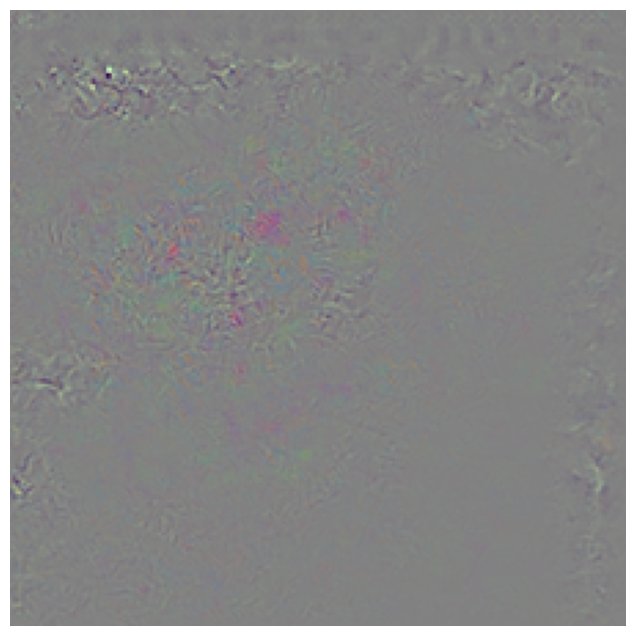

In [ ]:
#loss gradient
loss_gradient = classifier.loss_gradient(x=x_art, y=to_categorical([label], nb_classes=1000))

#plot the loss gradient
#swap channels back to rbg order?
loss_gradient_plot = loss_gradient[0]

#normalize the loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot- loss_gradient_min) / (loss_gradient_max - loss_gradient_min)

#show plot
plt.figure(figsize=(8,8)); plt.imshow(loss_gradient_plot); plt.axis('off'); plt.show()

#loss is just the amount of error we have between what a collection of pixels is recognized as versus what it should be. for example, the black edge of the tire should be a 1.0 as tire, but if it comes back as .6 then it's a .4 loss.
#the graph below shows where we have particularly lossy collections of pixels. note: this requires access to model weights

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

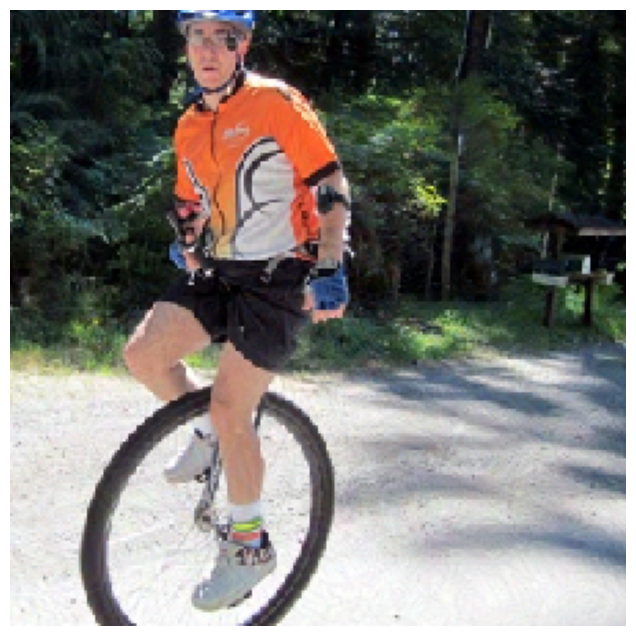

Prediction: mountain bike, all-terrain bike, off-roader - confidence 1.00


In [ ]:
#creating a targeted gradient descent attack; e.g., in the model look for the closest area that represents something other than a unicycle and change model weights randomly to get there.

adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)

x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

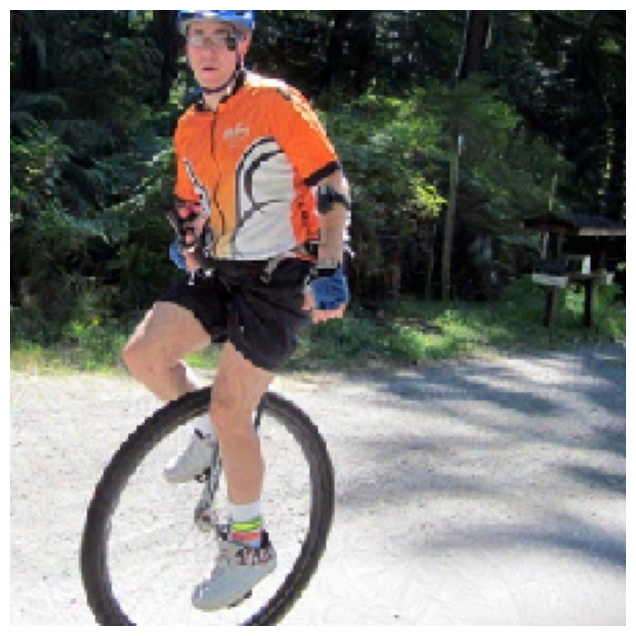

NameError: ignored

In [ ]:
target_label = 51 #51 = triceratops

# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

*italicized text*# MNIST & transferability


In [ ]:
# -*- coding: utf-8 -*-
"""Trains a CNN on the MNIST dataset using the Keras backend, then generates adversarial images using DeepFool
and uses them to attack a CNN trained on MNIST using TensorFlow. This is to show how to perform a
black-box attack: the attack never has access to the parameters of the TensorFlow model.
"""
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

from art.attacks.evasion import DeepFool
from art.estimators.classification import KerasClassifier, TensorFlowClassifier
from art.utils import load_mnist


def cnn_mnist_tf(input_shape):
    labels_tf = tf.placeholder(tf.float32, [None, 10])
    inputs_tf = tf.placeholder(tf.float32, [None] + list(input_shape))

    # Define the TensorFlow graph
    conv = tf.layers.conv2d(inputs_tf, 4, 5, activation=tf.nn.relu)
    conv = tf.layers.max_pooling2d(conv, 2, 2)
    fc = tf.contrib.layers.flatten(conv)

    # Logits layer
    logits = tf.layers.dense(fc, 10)

    # Train operator
    loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels_tf))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_tf = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    classifier = TensorFlowClassifier(
        clip_values=(0, 1), input_ph=inputs_tf, output=logits, loss=loss, train=train_tf, labels_ph=labels_tf, sess=sess
    )
    return classifier


def cnn_mnist_k(input_shape):
    # Create simple CNN
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(5, 5), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
    )

    classifier = KerasClassifier(model=model, clip_values=(0, 1))
    return classifier


# Get session
session = tf.compat.v1.Session()
k.set_session(session)

# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Construct and train a convolutional neural network on MNIST using Keras
source = cnn_mnist_k(x_train.shape[1:])
source.fit(x_train, y_train, nb_epochs=5, batch_size=128)

# Craft adversarial samples with DeepFool
adv_crafter = DeepFool(source)
x_train_adv = adv_crafter.generate(x_train)
x_test_adv = adv_crafter.generate(x_test)

# Construct and train a convolutional neural network
target = cnn_mnist_tf(x_train.shape[1:])
target.fit(x_train, y_train, nb_epochs=5, batch_size=128)

# Evaluate the CNN on the adversarial samples
preds = target.predict(x_test_adv)
acc = np.sum(np.equal(np.argmax(preds, axis=1), np.argmax(y_test, axis=1))) / y_test.shape[0]
print("\nAccuracy on adversarial samples: %.2f%%" % (acc * 100))